In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from keras_preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
num_of_gpu = len(tf.config.experimental.list_physical_devices('GPU'))

train_on_gpu = num_of_gpu > 0 

In [4]:
root_dir = 'drive/My Drive/Lab' 
# if train_on_gpu else '.'

data_dir = os.path.join(root_dir, 'data/')
output_dir = os.path.join(root_dir, 'output/')

csv_dir = os.path.join(data_dir, 'csv/')
images_dir = os.path.join(data_dir, 'images/')

training_file = os.path.join(csv_dir, 'train_data.csv')

testing_file = os.path.join(csv_dir, 'test_data.csv')

In [5]:
training_df = pd.read_csv(training_file, index_col=0)
testing_df = pd.read_csv(testing_file, index_col=0)

In [6]:
training_df['pneumonia'] = training_df['pneumonia'].astype(str)
testing_df['pneumonia'] = testing_df['pneumonia'].astype(str)

In [7]:
batch_size = 32
image_size = (224, 224)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.1, 
    width_shift_range=0.1, 
    rotation_range=20,
    shear_range = 0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [9]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=image_size,
    subset='training'
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=image_size,
    subset='validation'
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=image_size
)

Found 3588 validated image filenames belonging to 2 classes.
Found 897 validated image filenames belonging to 2 classes.
Found 1121 validated image filenames belonging to 2 classes.


In [10]:
num_classes = 2

In [11]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

IMG_WIDTH, IMG_HEIGHT = image_size

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

feature_extractor.trainable = False

In [12]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            1280, 
            activation = 'relu', 
        ),
        tf.keras.layers.Dense(
            540, 
            activation = 'relu'
        ),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              2622720   
_________________________________________________________________
dense_1 (Dense)              (None, 540)               691740    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1082      
Total params: 26,880,342
Trainable params: 3,315,542
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

36/36 [==============================] - 25s 708ms/step - loss: 0.8486 - accuracy: 0.4764

Loss before training: 0.849
Accuracy before training: 47.636%


In [15]:
EPOCHS = 500

model_file = os.path.join(output_dir, 'model.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', 
                    patience=5
                 )

save_best = tf.keras.callbacks.ModelCheckpoint(
                model_file, 
                monitor='val_accuracy', 
                save_best_only=True
            )

history = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    validation_data=valid_generator, 
    callbacks=[early_stopping, save_best]
)

Epoch 1/500
113/113 [==============================] - 148s 1s/step - loss: 0.8273 - accuracy: 0.6087 - val_loss: 0.6022 - val_accuracy: 0.6778
Epoch 2/500
113/113 [==============================] - 149s 1s/step - loss: 0.5879 - accuracy: 0.6904 - val_loss: 0.5141 - val_accuracy: 0.7492
Epoch 3/500
113/113 [==============================] - 149s 1s/step - loss: 0.5392 - accuracy: 0.7285 - val_loss: 0.4865 - val_accuracy: 0.7737
Epoch 4/500
113/113 [==============================] - 148s 1s/step - loss: 0.4983 - accuracy: 0.7561 - val_loss: 0.5035 - val_accuracy: 0.7414
Epoch 5/500
113/113 [==============================] - 148s 1s/step - loss: 0.4820 - accuracy: 0.7695 - val_loss: 0.4097 - val_accuracy: 0.7993
Epoch 6/500
113/113 [==============================] - 148s 1s/step - loss: 0.4315 - accuracy: 0.7993 - val_loss: 0.3405 - val_accuracy: 0.8618
Epoch 7/500
113/113 [==============================] - 146s 1s/step - loss: 0.3990 - accuracy: 0.8177 - val_loss: 0.3329 - val_accuracy:

In [16]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

36/36 [==============================] - 26s 720ms/step - loss: 0.0618 - accuracy: 0.9857

Loss after training: 0.062
Accuracy after training: 98.573%


In [17]:
final_model_file = os.path.join(output_dir, 'final-model.h5')

model.save(final_model_file)

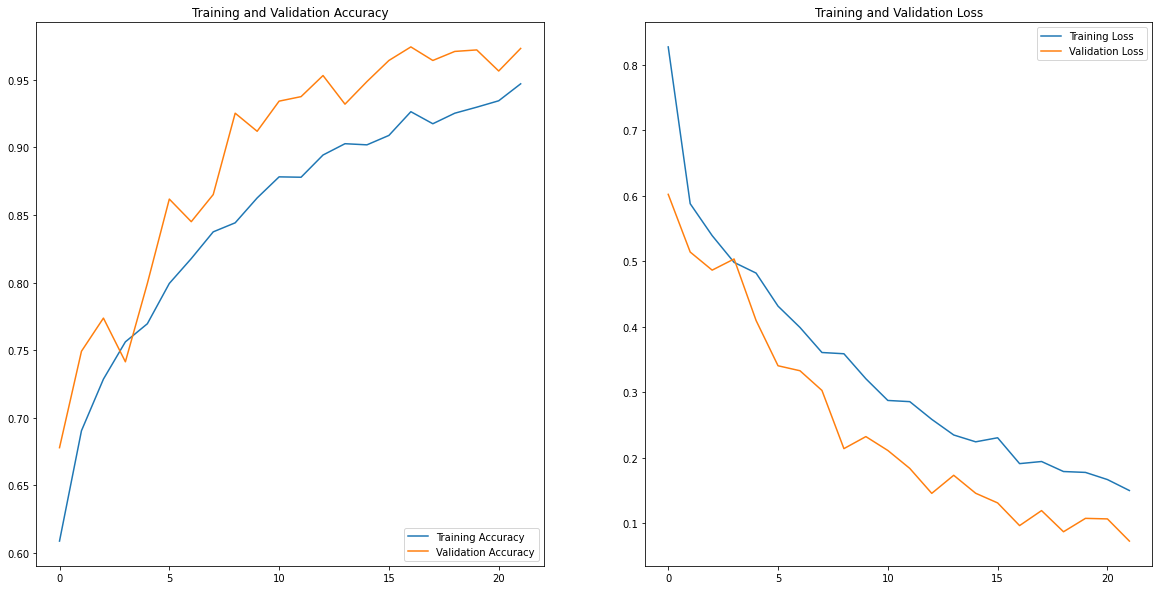

In [18]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()